# 通过密度反推 Kohn-Sham 势函数：消除 Gaussian 基组扰动现象

我们这里会尝试学习与复现文章的一些结果：

> Gaiduk, A. P.; Ryabinkin, I. G.; Staroverov, V. N.
> 
> Removal of Basis-Set Artifacts in Kohn−Sham Potentials Recovered from Electron Densities
>
> *J. Chem. Theory Comput.* **2013**, *9*, 3959-3964
>
> doi: [https://dx.doi.org/10.1021/ct4004146](10.1021/ct4004146)

这篇文章比较接近一篇技术讨论文章。在 KS (Kohn-Sham) 框架下，以及有了 KS 轨道能与轨道函数的情况下，我们能反推其 KS 势函数 $v_\mathrm{xc} (\boldsymbol{r})$。但若使用 Gaussian 基组反推 $v_\mathrm{xc} (\boldsymbol{r})$，则会出现严重的振荡。这篇文章希望能解决这种振荡现象。

## 准备工作

这篇文档统一使用原子单位。文档统一使用 RKS (Restricted Kohn-Sham)，即占据轨道的占据数统一为 2。因此，一些公式上可能在细节上，与 Gaiduk 文章细微出入。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 4 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

`ni` 是 PySCF 中用于进行格点积分的实用的变量。其使用方式可以参考 [pyxdh 文档](https://py-xdh.readthedocs.io/zh_CN/latest/qcbasic/basic_gga.html)。

In [2]:
ni = dft.numint.NumInt()

在文章初期，我们讨论的分子始终是单个 Ne 原子的 6-311G 基组。

In [3]:
mol = gto.Mole()
mol.atom = """Ne"""
mol.basis = "6-311G"
mol.verbose = 0
mol.build()

对于当前分子，我们使用的格点 `grids` 会稍许特别一些。我们使用角向密度相当高的格点 (100, 5810)。同时，我们对格点的坐标与权重作缩放，使得格点相对来说比较富集在院子周围。之所以设定的角向格点密度相当高，是因为我们需要保证 Hartree 势能 $v_\mathrm{H} (\boldsymbol{r})$ 的精度。之后我们会说明。

In [4]:
grids = dft.Grids(mol)
grids.atom_grid = (100, 5810)
grids.prune = None
grids.build()
grids.weights.size

581000

作为对比，我们会用 `grids_coarse` 来表示较低的角向密度格点。尽管该格点 (99, 590) 通常情况下足够应对量化计算了，但我们仍然会指出该格点大小的不足。

In [5]:
grids_coarse = dft.Grids(mol)
grids_coarse.atom_grid = (99, 590)
grids_coarse.build()

我们在开始讨论的时候，会仅使用 Slater 交换能进行计算。等到后面讨论时，我们再作更多其它泛函的说明。

In [6]:
mf = dft.RKS(mol)
mf.xc = "Slater"
mf.grids = grids
mf.run()

我们定义下述变量：

- `nmo` $n_\mathrm{MO}$, `nao` $n_\mathrm{AO}$：分子轨道数量或原子轨道数量

- `nocc` $n_\mathrm{occ}$：占据轨道数量

- `natm` $n_\mathrm{atom}$：原子数量

- `so`：占据轨道分割，用于程序的编写

In [7]:
nmo, nao, nocc, natm = mol.nao, mol.nao, mol.nelec[0], mol.natm
so = slice(0, nocc)

- `D` $D_{\mu \nu}$：密度矩阵

- `C` $C_{\mu p}$, `Co` $C_{\mu i}$：系数轨道矩阵

- `e` $\varepsilon_p$, `eo` $\varepsilon_i$：Canonical Kohn-Sham 轨道能

In [8]:
D, C, e = mf.make_rdm1(), mf.mo_coeff, mf.mo_energy
Co, eo = C[:, so], e[so]

- `rho_0` $\rho(\boldsymbol{r}_g)$：电子态密度，其中 $g$ 代表格点。我们这里不采用 [pyxdh 文档](https://py-xdh.readthedocs.io/zh_CN/latest/qcbasic/basic_gga.html) 的记号方式，并且在出现格点积分时会明确地写出格点权重 $w_g$。

In [9]:
ao_0 = ni.eval_ao(mol, grids.coords, deriv=0)
rho_0 = ni.eval_rho(mol, ao_0, D)

- `rad_ngrid`：径向格点数量，用于作图

- `rad_x`：径向格点的 $x$ 坐标分量 (格点到原子核间距离)，生成方式为从 $10^{-3}$ 到 $10^{1}$ 的长度为 1000 的等比数列

- `rad_coord`：径向格点的三维坐标

In [10]:
rad_ngrid = 1000
rad_x = np.logspace(-3, 1, rad_ngrid)
rad_coord = np.array([rad_x, np.zeros(rad_ngrid), np.zeros(rad_ngrid)]).T

以上述的径向格点 (即 $\boldsymbol{r}_g = (x_g, 0, 0)$)，我们可以生成原子轨道函数的数值大小。

- `rad_ao_0` $\phi_{\mu} (\boldsymbol{r}_g)$ 原子轨道 $\mu$ 函数在格点上的数值

- `rad_ao_2` $\phi_{ts} (\boldsymbol{r}_g)$ 原子轨道 $\mu$ 函数的二阶导数 $\partial_t \partial_s \phi_{\mu} (\boldsymbol{r}_g)$ 在格点上的数值，其中 $t, s$ 代表电子坐标的分量

In [11]:
rad_ao = ni.eval_ao(mol, rad_coord, deriv=2)
rad_ao_0 = rad_ao[0]
rad_ao_2 = np.array([
    [rad_ao[4], rad_ao[5], rad_ao[6]],
    [rad_ao[5], rad_ao[7], rad_ao[8]],
    [rad_ao[6], rad_ao[8], rad_ao[9]],
])

- `rad_occ_0` $\phi_i (\boldsymbol{r}_g)$ 分子轨道 $i$ 函数在格点上的数值，通过 $\phi_i = \sum_\mu \phi_\mu C_{\mu i}$ 得到

- `rad_occ_2` $\phi_{tsi} (\boldsymbol{r}_g)$，等价于 $\partial_t \partial_s \phi_i (\boldsymbol{r}_g)$

- `rad_rho_0` $\rho (\boldsymbol{r}_g)$，但该密度只表示在径向 $\boldsymbol{r}_g = (x_g, 0, 0)$ 上的格点，与 `rho_0` 尽管物理意义相同，但后者的格点是全空间的，可以被积分的格点

In [12]:
rad_occ_0 = np.einsum("gu, ui -> gi", rad_ao_0, Co)
rad_occ_2 = np.einsum("tsgu, ui -> tsgi", rad_ao_2, Co)
rad_rho_0 = np.einsum("gu, gv, uv -> g", rad_ao_0, rad_ao_0, D)

## 逆向求取 Kohn-Sham 交换相关势

我们从 Kohn-Sham 方程出发：

$$
\left[ - \frac{1}{2} \nabla^2 + v_\mathrm{eff} (\boldsymbol{r}) \right] \phi_i (\boldsymbol{r}) = \varepsilon_i \phi_i (\boldsymbol{r})
$$

对上式的左边乘上 $\phi_i (\boldsymbol{r})$，得到 (我们这里始终在实空间下讨论)

$$
- \frac{1}{2} \phi_i (\boldsymbol{r}) \nabla^2 \phi_i (\boldsymbol{r}) + v_\mathrm{eff} (\boldsymbol{r}) \phi_i^2 (\boldsymbol{r}) = \varepsilon_i \phi_i^2 (\boldsymbol{r})
$$

留意到，若对于 RKS (Restricted Kohn-Sham) 而言，每个占据轨道的占据数都是 2，因此

$$
\rho(\boldsymbol{r}) = \sum_{i} 2 \phi_i^2 (\boldsymbol{r})
$$

In [13]:
np.allclose(2 * (rad_occ_0**2).sum(axis=-1), rad_rho_0)

True

那么，我们对上上式的角标 $i$ 求和并乘以 2，得到

$$
- \sum_i \phi_i (\boldsymbol{r}) \nabla^2 \phi_i (\boldsymbol{r}) + \rho(\boldsymbol{r}) v_\mathrm{eff} (\boldsymbol{r}) = \sum_i 2 \varepsilon_i \phi_i^2 (\boldsymbol{r})
$$

整理上式，得到

$$
v_\mathrm{eff} (\boldsymbol{r}) = \frac{1}{\rho(\boldsymbol{r})} \sum_{i} \left[ \phi_i (\boldsymbol{r}) \nabla^2 \phi_i (\boldsymbol{r}) + 2 \varepsilon_i \phi_i^2 (\boldsymbol{r}) \right]
$$

从实现的角度上来讲，上式应写成 `rad_veff` $v_\mathrm{eff} (\boldsymbol{r}_g)$

$$
v_\mathrm{eff} (\boldsymbol{r}_g) = \frac{1}{\rho(\boldsymbol{r}_g)} \sum_{i} \left[ \sum_t \phi_i (\boldsymbol{r}_g) \phi_{ti} (\boldsymbol{r}_g) + 2 \varepsilon_i \phi_i^2 (\boldsymbol{r}_g) \right]
$$

In [14]:
rad_veff = (
    + np.einsum("gi, git -> g", rad_occ_0, rad_occ_2.diagonal())
    + 2 * np.einsum("i, gi, gi -> g", eo, rad_occ_0, rad_occ_0)
) / rad_rho_0

<IPython.core.display.Javascript object>


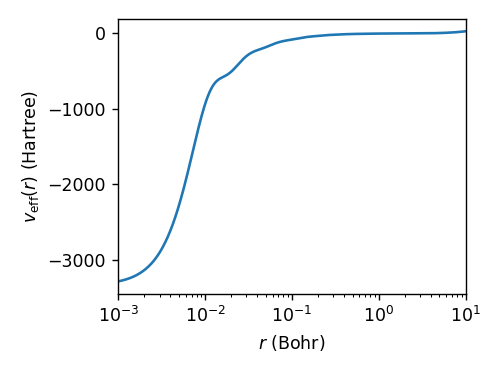

In [15]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, rad_veff)
ax.set_xscale("log")
ax.set_xlim(1e-3, 1e1)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$v_\mathrm{eff} (r)$ (Hartree)")
fig.tight_layout()

但上述势能并非交换相关势。根据交换相关势的定义，我们会写

$$
v_\mathrm{xc} (\boldsymbol{r}) = v_\mathrm{eff} (\boldsymbol{r}) - v_\mathrm{ext} (\boldsymbol{r}) - v_\mathrm{H} (\boldsymbol{r})
$$

其中，我们已经获得了有效势 `rad_veff` $v_\mathrm{eff} (\boldsymbol{r}_g)$；外势 `rad_vext` $v_\mathrm{ext} (\boldsymbol{r}_g)$ 被定义为电子与原子核的静电吸引作用：

$$
v_\mathrm{ext} (\boldsymbol{r}_g) = \sum_{A} \frac{- Z_A}{|\boldsymbol{r}_g - \boldsymbol{A}|}
$$

其中，斜体的 $A$ 代表分子中的原子，粗斜体的 $\boldsymbol{A}$ 代表原子坐标。当然，我们现在考虑的分子还只是 Ne 原子，因此只有一个原子：

In [16]:
rad_vext = np.zeros_like(rad_veff)
for A in range(natm):
    rad_vext += - mol.atom_charge(A) / np.linalg.norm(rad_coord - mol.atom_coord(A), axis=-1)

Hartree 势 `rad_vH` $v_\mathrm{H} (\boldsymbol{r}_g)$ 是电子之间相互静电排斥的势能，有时也会称为静电排斥势 (electrostatic potential) 或库伦排斥势 (Coulomb potential)。其定义为

$$
v_\mathrm{H} (\boldsymbol{r}) = \int \frac{\rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r}'
$$

现在，如果我们将沿着 $x$ 轴的径向格点标记为角标 $g$，全空间格点标记为角标 $G$，那么上述连续积分可以写为格点积分

$$
v_\mathrm{H} (\boldsymbol{r}_g) = \sum_G w_G \frac{\rho(\boldsymbol{r}_G)}{| \boldsymbol{r}_g - \boldsymbol{r}_G |}
$$

In [17]:
def get_vH_at_r(r):
    inverse_coords = np.copy(grids.coords)
    inverse_coords[:, 0] -= r
    return (grids.weights * rho_0 / np.linalg.norm(inverse_coords, axis=-1)).sum()

譬如说，如果现在我们考察距离原子 $10^{-2}$ Bohr 处的 Hartree 势 $v_\mathrm{H}$，那么我们可以通过下述代码给出：

In [18]:
get_vH_at_r(1e-2)

30.89707871844751

我们用下述的程序可以生成径向的 Hartree 势 `rad_vH` $v_\mathrm{H}$：

In [19]:
rad_vH = np.array([get_vH_at_r(r) for r in rad_x])

我们之前提起过，为了要准确计算 Hartree 势，我们需要增大角向格点。如果不增大角向格点，譬如用 (99, 590) 格点 (对于一般的 DFT 计算而言是足够大的格点了)，生成的 Hartree 势则记为 `rad_vH_coarse`：

In [20]:
rho_0_coarse = ni.eval_rho(mol, ni.eval_ao(mol, grids_coarse.coords, deriv=0), D)
def get_vH_coarse_at_r(r):
    inverse_coords = np.copy(grids_coarse.coords)
    inverse_coords[:, 0] -= r
    return (rho_0_coarse / np.linalg.norm(inverse_coords, axis=-1) * grids_coarse.weights).sum()
rad_vH_coarse = np.array([get_vH_coarse_at_r(r) for r in rad_x])

我们绘制这两种不同的格点所生成的 Hartree 势：

<IPython.core.display.Javascript object>


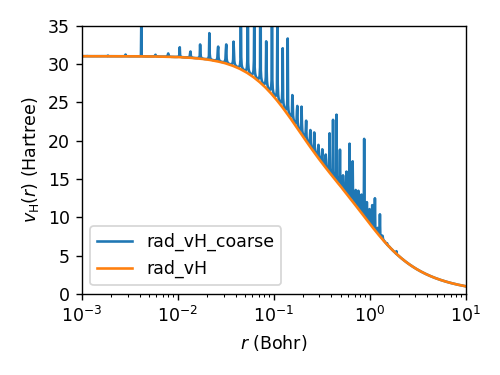

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, rad_vH_coarse, label="rad_vH_coarse")
ax.plot(rad_x, rad_vH, label="rad_vH")
ax.set_xscale("log"), ax.legend()
ax.set_xlim(1e-3, 1e1), ax.set_ylim(0, 35)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$v_\mathrm{H} (r)$ (Hartree)")
fig.tight_layout()

因此，对于当前的体系而言，我们不一定需要很高的径向格点，但一定需要很高的角向格点，才能描述好 Hartree 势。但事实上，即使是橙色的曲线，也有粗糙和突跃的地方。这很有可能表明计算 Hartree 势函数可能不适合用格点积分，而应当用离散傅里叶变换更为合适。但作者限于能力，暂时还不会使用离散傅里叶变换处理当前的问题。

In [22]:
# For Fourier transformation of this problem, the following html could be instructive. However, I haven't tried that out.
# https://www.tcm.phy.cam.ac.uk/~pdh1001/thesis/node39.html

那既然我们已经知道了外势与 Hartree 势，我们就可以求出交换相关势了 `rad_vxc` $v_\mathrm{xc} (\boldsymbol{r}_g)$：

$$
v_\mathrm{xc} (\boldsymbol{r}_g) = v_\mathrm{eff} (\boldsymbol{r}_g) - v_\mathrm{ext} (\boldsymbol{r}_g) - v_\mathrm{H} (\boldsymbol{r}_g)
$$

In [23]:
rad_vxc = rad_veff - rad_vext - rad_vH

或许读者会奇怪，我们上面所用的自洽场方法是 Slater 交换能，而没有使用到相关泛函。需要指出，如果自洽场中，用到的是交换相关泛函，那么上面的过程可以一样地处理。我们在这里可以用 PySCF 的程序给出 Slater 泛函的形式 `rad_vx_slater` $v_\mathrm{x}^\mathsf{Slater} (\boldsymbol{r}_g)$，当然也可以通过 Slater 泛函的定义给出：

In [24]:
# PySCF approach: rad_vx_slater = ni.eval_xc("Slater", rad_rho_0, deriv=1)[1][0]
rad_vx_slater = - (3 / np.pi)**(1 / 3) * rad_rho_0**(1 / 3) 

原文的 Figure 1 对我们通过轨道、轨道能给出的外势、进而重构的交换相关势 (reconstructed) `rad_vxc` 与真实的交换相关势 (original) `rad_vx_slater` 做了比较。可以看出，我们重构的交换相关势的振荡相当严重。

<IPython.core.display.Javascript object>


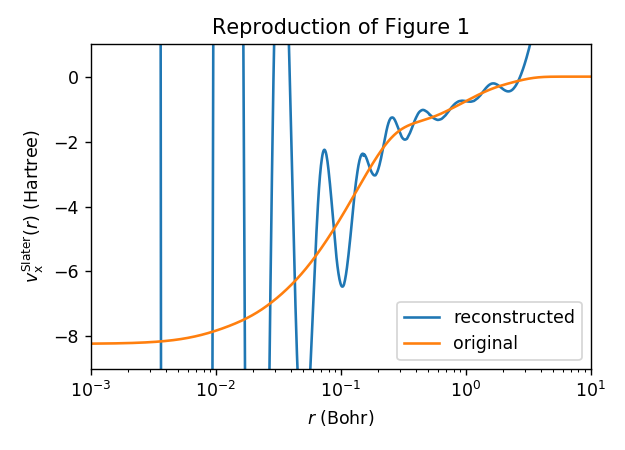

In [25]:
fig, ax = plt.subplots(figsize=(5, 3.6))
ax.plot(rad_x, rad_vxc, label="reconstructed")
ax.plot(rad_x, rad_vx_slater, label="original")
ax.set_xscale("log"), ax.legend()
ax.set_xlim(1e-3, 1e1), ax.set_ylim(-9, 1)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$v_\mathrm{x}^\mathsf{Slater} (r)$ (Hartree)")
ax.set_title("Reproduction of Figure 1")
fig.tight_layout()

## 振荡的特性

这样的振荡可以定量为

$$
\Delta v_\mathrm{osc} (\boldsymbol{r}) = v_\mathrm{xc}^\mathrm{reconstructed} (\boldsymbol{r}) - v_\mathrm{xc}^\mathrm{original} (\boldsymbol{r})
$$

这样的振荡是有规律可循的。我们定义下述函数，其输入 `mol` 是分子的实例，`xc` 是交换相关泛函的字符串表达；输出 `rad_vxc_reconstructed` 是通过 Gaiduk 文中所述过程得到的 (强烈振荡的) 交换相关势函数格点 $v_\mathrm{xc}^\mathrm{reconstructed} (\boldsymbol{r}_g)$，`rad_vxc_original` 是真实的交换相关势函数格点 $v_\mathrm{xc}^\mathrm{original} (\boldsymbol{r}_g)$。

PBE 的交换相关势函数的导出并非相当容易，它不像 LDA 型的泛函一样可以通过泛函核关于密度的偏导数直接获得。[前一份文档](PBE_xc_potential.ipynb) 就是为了解决如何获取 PBE 精确的交换相关势而写的文档。

In [26]:
def gen_rad_xc(mol, xc, rad_x=None):
    ni = dft.numint.NumInt()       # DFT numerical integral engine
    # === Grid Build ===
    grids = dft.Grids(mol)         #
    grids.atom_grid = (100, 5810)  # set grid with radial 100, angular 5810
    grids.prune = None             # do not prune grid, i.e. don't change angular grid point size on the sphere too far or too close to neucleu
    grids.build()                  #
    # === SCF Instance ===
    mf = dft.RKS(mol)              #
    mf.xc = xc                     # set exchange-correlation code (like `Slater`, `PBE`) to SCF instance
    mf.grids = grids               # set grid to SCF instance
    mf.run()                       # run SCF instance to generate density, molecular orbital coefficient
    nmo, nao, nocc, natm = mol.nao, mol.nao, mol.nelec[0], mol.natm
    so = slice(0, nocc)
    D, C, e = mf.make_rdm1(), mf.mo_coeff, mf.mo_energy
    Co, eo = C[:, so], e[so]
    # === Grided Density Generation === (for computation, not for plot)
    ao_0 = ni.eval_ao(mol, grids.coords, deriv=0)
    rho_0 = ni.eval_rho(mol, ao_0, D)
    # === Radial Grid Generation ===
    rad_ngrid = 1000
    if rad_x is None:
        rad_x = np.logspace(-3, 1, rad_ngrid)
    else:
        rad_ngrid = rad_x.size
    rad_coord = np.array([rad_x, np.zeros(rad_ngrid), np.zeros(rad_ngrid)]).T
    # === Radial Grid Atomic Orbital and its Derivative ===
    rad_ao = ni.eval_ao(mol, rad_coord, deriv=2)
    rad_ao_0, rad_ao_1 = rad_ao[0], rad_ao[1:4]
    rad_ao_2 = np.array([
        [rad_ao[4], rad_ao[5], rad_ao[6]],
        [rad_ao[5], rad_ao[7], rad_ao[8]],
        [rad_ao[6], rad_ao[8], rad_ao[9]],
    ])
    # === Radial Grid Density, Gamma and their Derivative ===
    rad_rho_0 = np.einsum("gu, gv, uv -> g", rad_ao_0, rad_ao_0, D)
    rad_rho_1 = 2 * np.einsum("rgu, gv, uv -> rg", rad_ao_1, rad_ao_0, D)
    rad_rho_2 = (
        + 2 * np.einsum("rwgu, gv, uv -> rwg", rad_ao_2, rad_ao_0, D)
        + 2 * np.einsum("rgu, wgv, uv -> rwg", rad_ao_1, rad_ao_1, D)
    )
    rad_gamma_0 = np.einsum("rg, rg -> g", rad_rho_1, rad_rho_1)
    rad_gamma_1 =  2 * np.einsum("rwg, wg -> rg", rad_rho_2, rad_rho_1)
    # === Radial Grid Occupied Molecular Orbital and its Derivative ===
    rad_occ_0 = np.einsum("gu, ui -> gi", rad_ao_0, Co)
    rad_occ_2 = np.einsum("tsgu, ui -> tsgi", rad_ao_2, Co)
    # === Veff (generated from eq(2) in article) ===
    rad_veff = (
        + np.einsum("gi, git -> g", rad_occ_0, rad_occ_2.diagonal())
        + 2 * np.einsum("i, gi, gi -> g", eo, rad_occ_0, rad_occ_0)
    ) / rad_rho_0
    # === Vxc (generated from eq(3) in article) ===
    rad_vext = np.zeros_like(rad_veff)
    for A in range(natm):
        rad_vext += - mol.atom_charge(A) / np.linalg.norm(rad_coord - mol.atom_coord(A), axis=-1)
    def get_vH_at_r(r):
        inverse_coords = np.copy(grids.coords)
        inverse_coords[:, 0] -= r
        return (grids.weights * rho_0 / np.linalg.norm(inverse_coords, axis=-1)).sum()
    rad_vH = np.array([get_vH_at_r(r) for r in rad_x])
    rad_vxc_reconstructed = rad_veff - rad_vext - rad_vH
    # === Generate True Vxc ===
    _, rad_vxc, rad_fxc, _ = ni.eval_xc(xc, np.concatenate([rad_rho_0[None, :], rad_rho_1]), deriv=2)
    rad_fr, rad_fg = rad_vxc[:2]
    rad_frr, rad_frg, rad_fgg = rad_fxc[:3]
    rad_vxc_original = np.copy(rad_fr)
    if rad_fg is not None:
        rad_vxc_original += (
            - 2 * np.einsum("g, rg, rg -> g", rad_frg, rad_rho_1, rad_rho_1)
            - 2 * np.einsum("g, rg, rg -> g", rad_fgg, rad_gamma_1, rad_rho_1)
            - 2 * np.einsum("g, gr -> g", rad_fg, rad_rho_2.diagonal())
        )
    # === Return === 1. Vxc from eq(3); 2. True Potential
    return rad_vxc_reconstructed, rad_vxc_original

我们可以获得 Slater 泛函下的计算与精确的交换相关势：

In [27]:
rad_vxc_reconstructed_slater, rad_vxc_original_slater = gen_rad_xc(mol, "Slater")

我们也可以获得 PBE 泛函下的对应：

In [28]:
rad_vxc_reconstructed_pbe, rad_vxc_original_pbe = gen_rad_xc(mol, "PBE")

我们随后绘制 Slater 泛函所产生的振荡 $\Delta v_\mathrm{osc}^\mathsf{Slater} (\boldsymbol{r})$ 与 PBE 泛函所产生的振荡 $\Delta v_\mathrm{osc}^\mathsf{PBE} (\boldsymbol{r})$。可以看出，这两者之间的振荡形状相当的接近，即

$$
\Delta v_\mathrm{osc}^\mathsf{Slater} (\boldsymbol{r}) \simeq v_\mathrm{osc}^\mathsf{PBE} (\boldsymbol{r})
$$

<IPython.core.display.Javascript object>


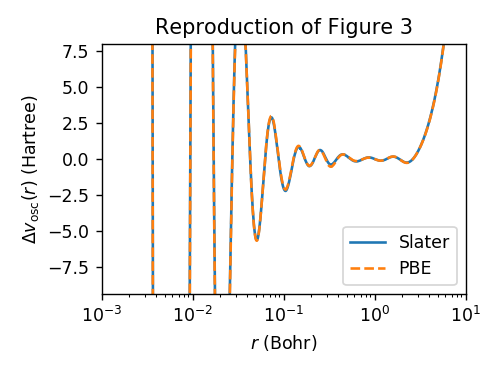

In [29]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, rad_vxc_reconstructed_slater - rad_vxc_original_slater, label="Slater")
ax.plot(rad_x, rad_vxc_reconstructed_pbe - rad_vxc_original_pbe, label="PBE", linestyle="--")
ax.set_xscale("log"), ax.legend()
ax.set_xlim(1e-3, 1e1), ax.set_ylim(-9.4, 8)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$\Delta v_\mathrm{osc} (r)$ (Hartree)")
ax.set_title("Reproduction of Figure 3")
fig.tight_layout()

## 平滑振荡的有效势

如果，我们现在假设我们不知道 PBE 交换相关泛函的真实构造，那么依据上面的结论，有

$$
\Delta v_\mathrm{osc}^\mathsf{Slater} (\boldsymbol{r}) \simeq v_\mathrm{osc}^\mathsf{PBE} (\boldsymbol{r}) = v_\mathrm{reconstructed}^\mathsf{PBE} (\boldsymbol{r}) - v_\mathrm{original}^\mathsf{PBE} (\boldsymbol{r})
$$

依据 Gaiduk 文章的 eq (8)，定义

$$
v_\mathrm{corrected}^\mathsf{PBE} (\boldsymbol{r}) = v_\mathrm{reconstructed}^\mathsf{PBE} (\boldsymbol{r}) - \Delta v_\mathrm{osc}^\mathsf{Slater} (\boldsymbol{r})
$$

我们应当预期，$v_\mathrm{corrected}^\mathsf{PBE} (\boldsymbol{r}) \simeq v_\mathrm{original}^\mathsf{PBE} (\boldsymbol{r})$。下图就展示，这两者确实非常接近。

<IPython.core.display.Javascript object>


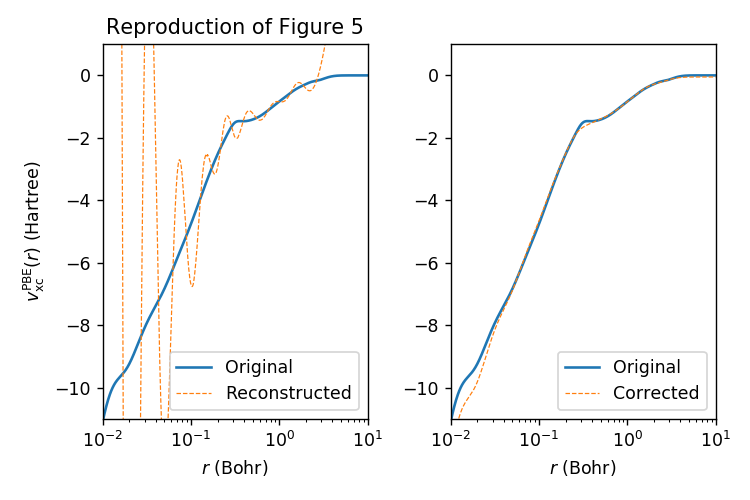

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].plot(rad_x, rad_vxc_original_pbe, label="Original")
ax[0].plot(rad_x, rad_vxc_reconstructed_pbe, label="Reconstructed", linestyle="--", linewidth=0.7)
ax[0].set_xscale("log"), ax[0].legend(loc="lower right")
ax[0].set_xlim(1e-2, 1e1), ax[0].set_ylim(-11, 1)
ax[0].set_xlabel(r"$r$ (Bohr)")
ax[0].set_ylabel(r"$v_\mathrm{xc}^\mathsf{PBE} (r)$ (Hartree)")
ax[0].set_title("Reproduction of Figure 5")
ax[1].plot(rad_x, rad_vxc_original_pbe, label="Original")
ax[1].plot(rad_x, rad_vxc_reconstructed_pbe - (rad_vxc_reconstructed_slater - rad_vxc_original_slater), label="Corrected", linestyle="--", linewidth=0.7)
ax[1].set_xscale("log"), ax[1].legend(loc="lower right")
ax[1].set_xlim(1e-2, 1e1), ax[1].set_ylim(-11, 1)
ax[1].set_xlabel(r"$r$ (Bohr)")
fig.tight_layout()

尽管平滑后的 $v_\mathrm{corrected}^\mathsf{PBE} (\boldsymbol{r})$ 与真实的 $v_\mathrm{original}^\mathsf{PBE} (\boldsymbol{r})$ 已经很接近了，但我们会发现，特别是在靠近核处的交换相关泛函，与真实值还是稍有差距。如果我们选用更大的基组 (或许是对靠近原子核部分描述更好的基组)，譬如 UGBS 基组，那么平滑后与真实交换相关势会更为相近。我们将 UGBS 基组所生成的分子写为 `mol_UGBS`：

In [31]:
mol_UGBS = gto.Mole()
mol_UGBS.atom = """Ne"""
with open("ugbs_Ar.txt", "r") as f:
    mol_UGBS.basis = gto.basis.parse(f.read())
mol_UGBS.verbose = 0
mol_UGBS.build()

下面我们就生成以 UGBS 基组构造的 Ne 分子生成的 Slater 与 PBE 的真实的以及反推演出来的交换相关势，并对 Gaiduk 文章的 Figure 6 进行绘制：

In [32]:
rad_vxc_reconstructed_slater, rad_vxc_original_slater = gen_rad_xc(mol_UGBS, "Slater")

In [33]:
rad_vxc_reconstructed_pbe, rad_vxc_original_pbe = gen_rad_xc(mol_UGBS, "PBE")

<IPython.core.display.Javascript object>


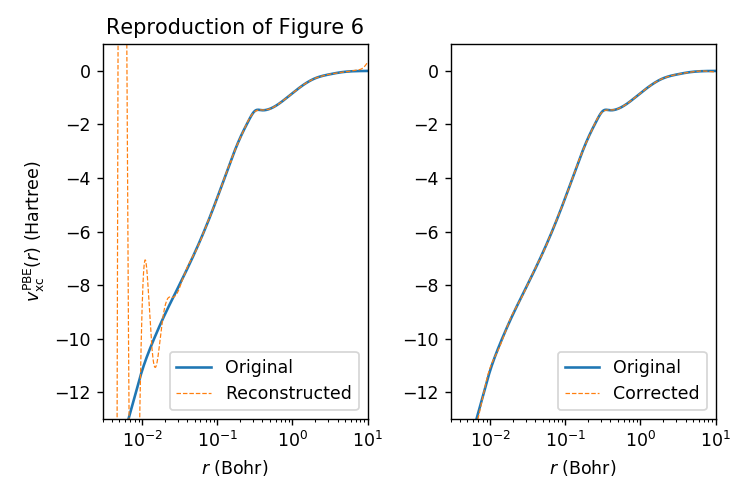

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].plot(rad_x, rad_vxc_original_pbe, label="Original")
ax[0].plot(rad_x, rad_vxc_reconstructed_pbe, label="Reconstructed", linestyle="--", linewidth=0.7)
ax[0].set_xscale("log"), ax[0].legend(loc="lower right")
ax[0].set_xlim(3e-3, 1e1), ax[0].set_ylim(-13, 1)
ax[0].set_xlabel(r"$r$ (Bohr)")
ax[0].set_ylabel(r"$v_\mathrm{xc}^\mathsf{PBE} (r)$ (Hartree)")
ax[0].set_title("Reproduction of Figure 6")
ax[1].plot(rad_x, rad_vxc_original_pbe, label="Original")
ax[1].plot(rad_x, rad_vxc_reconstructed_pbe - (rad_vxc_reconstructed_slater - rad_vxc_original_slater), label="Corrected", linestyle="--", linewidth=0.7)
ax[1].set_xscale("log"), ax[1].legend(loc="lower right")
ax[1].set_xlim(3e-3, 1e1), ax[1].set_ylim(-13, 1)
ax[1].set_xlabel(r"$r$ (Bohr)")
fig.tight_layout()

不只是原子适用于这种方法；对于分子也同样适用。Gaiduk 文章的图 8 就展示了这种可能性。原文中尝试给出 CO 在 Un-contracted 6-311G\* 基组下进行讨论 PBE 的交换相关势；但 PySCF 中若将基组完全拆开，容易在密度初猜过程中出现矩阵不可求逆的情况。因此，我们就使用普通的 6-311G\* 基组来作绘图。下面图片中，左边奇点代表碳原子，而右边奇点代表氧原子。

In [35]:
rad_x_CO = np.linspace(-3, 5, 2000)

mol_CO = gto.Mole()
mol_CO.atom = """
C -0.6017097690606921 0. 0.
O  0.5264960462082796 0. 0.
"""
mol_CO.basis = "6-311G*"
mol_CO.verbose = 0
mol_CO.build()

In [36]:
rad_vxc_reconstructed_slater, rad_vxc_original_slater = gen_rad_xc(mol_CO, "Slater", rad_x=rad_x_CO)

In [37]:
rad_vxc_reconstructed_pbe, rad_vxc_original_pbe = gen_rad_xc(mol_CO, "PBE", rad_x=rad_x_CO)

<IPython.core.display.Javascript object>


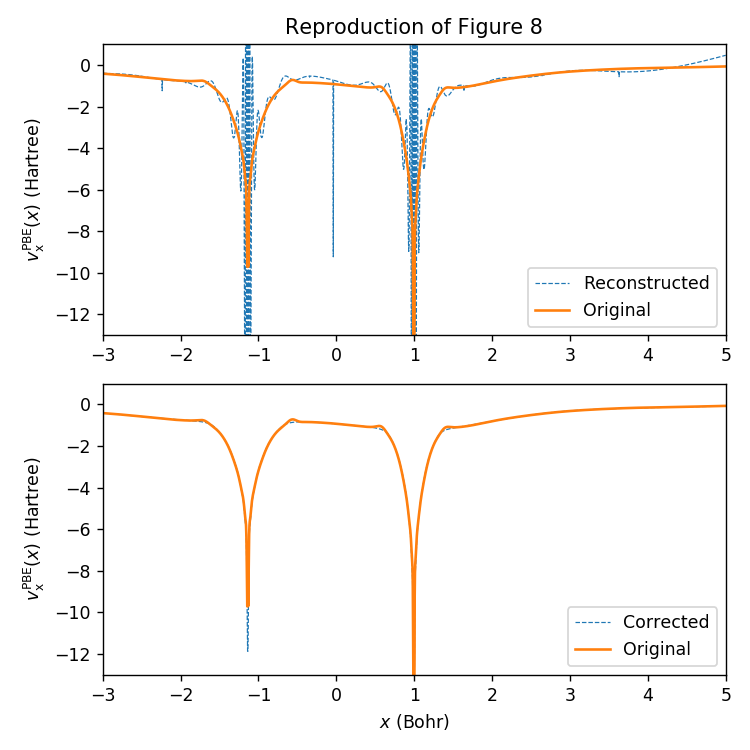

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(rad_x_CO, rad_vxc_reconstructed_pbe, label="Reconstructed", linestyle="--", linewidth=0.7)
ax[0].plot(rad_x_CO, rad_vxc_original_pbe, label="Original")
ax[0].legend()
ax[0].set_xlim(-3, 5), ax[0].set_ylim(-13, 1)
ax[0].set_ylabel(r"$v_\mathrm{x}^\mathsf{PBE} (x)$ (Hartree)")
ax[0].set_title("Reproduction of Figure 8")
ax[1].plot(rad_x_CO, rad_vxc_reconstructed_pbe - (rad_vxc_reconstructed_slater - rad_vxc_original_slater), label="Corrected", linestyle="--", linewidth=0.7)
ax[1].plot(rad_x_CO, rad_vxc_original_pbe, label="Original")
ax[1].legend()
ax[1].set_xlim(-3, 5), ax[1].set_ylim(-13, 1)
ax[1].set_xlabel(r"$x$ (Bohr)")
ax[1].set_ylabel(r"$v_\mathrm{x}^\mathsf{PBE} (x)$ (Hartree)")
fig.tight_layout()

## 未尽事项

在 Gaiduk 文章中，还提及了两个消除 Gaussian 基组扰动的交换相关势的应用与验证。其一是 Figure 9 所呈现的对没有具体交换相关形式的方法 (譬如 Hartree-Fock)，要如何得到平滑且近乎正确的交换相关势；其二是 Figure 10 中验证的通过平滑之后的交换相关势，在自洽场过程下，确实能得到相同的密度格点。前者由于利用到 Density-to-Potential Mapping 方法，在对其进行理解后，可能会在以后的文档作补充。